
# MTGAN Model
https://review.udacity.com/#!/reviews/655271

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import cv2
import pickle as pkl
import os

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load dataset

In [2]:
img_files = os.listdir("cropped_dragon_imgs")

datalist = list()
for img_file in img_files:
    img = cv2.imread("cropped_dragon_imgs/" + img_file)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_res = cv2.resize(img_bgr, (240, 160))
    datalist.append(img_res)

dataset = np.array(datalist)
print(dataset.shape)

(377, 160, 240, 3)


(160, 240, 3)


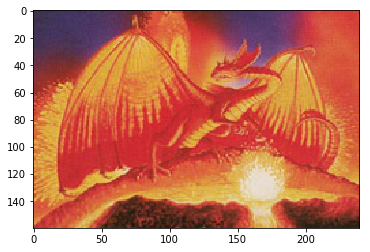

In [3]:
#Load a random img
rand_img = dataset[np.random.randint(0,len(dataset))]
plt.imshow(rand_img)
print(rand_img.shape)

4 12 36 108 64 128 256
2 6  18 54 162

250 

240 120 60 30   15   5 
160 80  40 20   10   5
3   32  64 128  256  512     

In [4]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

## Create model

In [5]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [6]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        if training:
            keep_prob = 0.5
        else:
            keep_prob = 1
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 5*5*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 5, 5, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob)
        # 5x5x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=(2,3), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 15x10x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 30x20x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=training)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob)
        # 60x40x64 now
        
        x5 = tf.layers.conv2d_transpose(x4, 32, 5, strides=2, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=training)
        x5 = tf.maximum(alpha * x5, x5)
        x5 = tf.nn.dropout(x5, keep_prob)
        # 120x80x32 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x5, output_dim, 5, strides=2, padding='same')
        # 240x160x3 now

        out = tf.tanh(logits)

        return out

In [7]:
#test_gen = generator(tf.placeholder(dtype=tf.float32, shape=[None, 100]),3, True)
#test_gen.get_shape()

In [8]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        keep_prob = 0.7
        
        # Input layer is 240x160x3
        x1 = tf.layers.conv2d(x, 32, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob)
        # 120x80x32
        #print(relu1.get_shape())
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob)
        # 60x40x64
        #print(relu2.get_shape())
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob)
        # 30x20x128
        #print(relu3.get_shape())
        
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.nn.dropout(relu4, keep_prob)
        # 15x10x256
        #print(relu4.get_shape())
        
        x5 = tf.layers.conv2d(relu4, 512, 5, strides=(2,3), padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn5 = tf.layers.batch_normalization(x5, training=True)
        relu5 = tf.maximum(alpha * bn5, bn5)
        relu5 = tf.nn.dropout(relu5, keep_prob)
        # 5x5x512
        
        #print(relu5.get_shape())

        # Flatten it
        #flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.contrib.layers.flatten(relu5)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        #print(flat.get_shape())
        
        return out, logits

In [9]:
#test_disc , log = discriminator(tf.placeholder(shape=[None, 160, 240, 3], dtype=tf.float32))
#test_disc.get_shape()

In [21]:
def model_loss_w(input_real, input_z, output_dim, alpha=0.2):
    
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
        
    d_loss = tf.reduce_mean(d_logits_fake) - tf.reduce_mean(d_logits_real)  # This optimizes the discriminator.
    g_loss = -tf.reduce_mean(d_logits_fake) # This optimizes the generator.
    
    return d_loss, g_loss

In [22]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [24]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss_w(self.input_real, self.input_z, real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [25]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [26]:
def get_batches(dataset, batch_size):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i:i+batch_size]

In [44]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        #sess.run(tf.global_variables_initializer())
        saver.restore(sess, './checkpoints/generator.ckpt')
        for e in range(epochs):
            #for x, y in dataset.batches(batch_size):
            for x in get_batches(dataset, batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: scale(x), net.input_z: batch_z})
                #Cant run g.opt without net.input_real: scale(x) proabably due to tf.control_dep that is used for batchnorm
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: scale(x)})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: scale(x)})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    fig, ax = plt.subplots()
                    losses_np = np.array(losses)
                    plt.plot(losses_np.T[0], label='Discriminator', alpha=0.5)
                    plt.plot(losses_np.T[1], label='Generator', alpha=0.5)
                    plt.title("Training Losses")
                    plt.legend()
                    
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [45]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()

In [46]:
#local_device_protos

#implement early stopping

In [47]:
real_size = (160,240,3)
z_size = 100
learning_rate = 0.0002
batch_size = 50
epochs = 500
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt


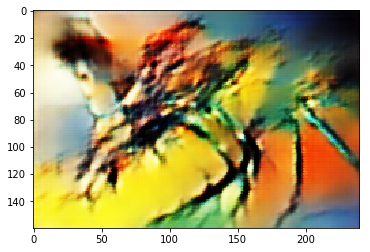

In [73]:
def gen_image():
    
    saver = tf.train.Saver()
    
    _, input_z = model_inputs(real_size, z_size)
    
    with tf.Session() as sess:
        #sess.run(tf.global_variables_initializer())
        saver.restore(sess, './checkpoints/generator.ckpt')
        
        latent_vec = np.random.uniform(-1, 1, size=(1, z_size))
        
        gen_samples = sess.run(generator(input_z, 3, reuse=True, training=False),
                                   feed_dict={input_z: latent_vec})
        for img in gen_samples:
            img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
            plt.imshow(img)
            plt.show()
            
gen_image()

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt
Epoch 2/500... Discriminator Loss: 6.4418... Generator Loss: -13.7944
Epoch 3/500... Discriminator Loss: -6.0294... Generator Loss: -8.0680
Epoch 4/500... Discriminator Loss: 13.9381... Generator Loss: -16.6826
Epoch 5/500... Discriminator Loss: -3.6347... Generator Loss: -8.3634
Epoch 7/500... Discriminator Loss: 19.7854... Generator Loss: -28.1682


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


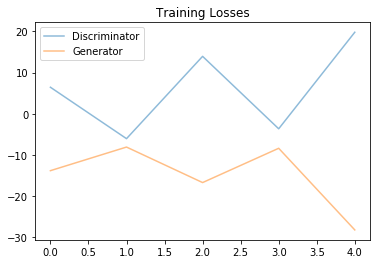

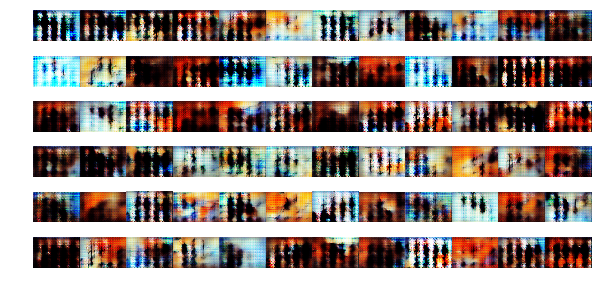

Epoch 8/500... Discriminator Loss: 2.1698... Generator Loss: -10.6980
Epoch 9/500... Discriminator Loss: -2.5446... Generator Loss: -3.8899
Epoch 10/500... Discriminator Loss: -10.9146... Generator Loss: -2.9436
Epoch 12/500... Discriminator Loss: 1.4233... Generator Loss: -7.2463
Epoch 13/500... Discriminator Loss: -1.0167... Generator Loss: 1.2533


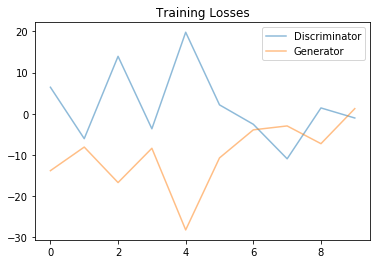

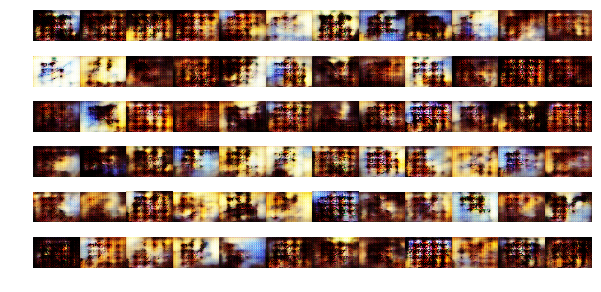

Epoch 14/500... Discriminator Loss: 12.9409... Generator Loss: -7.4710
Epoch 15/500... Discriminator Loss: 5.9419... Generator Loss: -6.0572
Epoch 17/500... Discriminator Loss: 9.8870... Generator Loss: -1.0003
Epoch 18/500... Discriminator Loss: 3.5102... Generator Loss: -1.5372


In [ ]:
losses, samples = train(net, dataset, epochs, batch_size, show_every=50, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [52]:
#samples = np.random.uniform(-1, 1, size=(72, z_size))
#_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

In [ ]:
_ = view_samples(-1, samples, 4, 6, figsize=(8.5,4))

In [ ]:
os.listdir("checkpoints")

In [ ]:
os.stat("checkpoints/generator.ckpt.data-00000-of-00001")

In [114]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

#if __name__ == '__main__':
    #zipf = zipfile.ZipFile('Python.zip', 'w', zipfile.ZIP_DEFLATED)
    #zipdir('tmp/', zipf)
    #zipf.close()

In [115]:
zipf = zipfile.ZipFile('checkpoints{}.zip'.format(time.time()), 'w', zipfile.ZIP_DEFLATED)
zipdir('checkpoints/', zipf)
zipf.close()

In [117]:
os.stat("checkpoints1519951842.344272.zip")

os.stat_result(st_mode=33204, st_ino=1559670, st_dev=51713, st_nlink=1, st_uid=1000, st_gid=1000, st_size=109546284, st_atime=1519951842, st_mtime=1519951848, st_ctime=1519951848)